![avatar](figures/front_banner_T1S0_new.png)

# SI100B Assignment 3 (Fall, 2021): 
# Appearance-based Gaze Estimation
*******
<br/>

Author: `Yintao Xu` | Modified by: `Yucong Chen`, `Yiwen Wu` | Proofread by: `Ziqi Gao`

Email: `{xuyt, chenyc, wuyw1, gaozq}@shanghaitech.edu.cn` | Update: `2021-11` 

### Section 0.1: Introduction

> Gaze tracking or gaze estimation is an important topic for understanding human visual attention. Such a technology has been widely deployed in various fields, such as human–computer interaction, visual behavior analysis, and psychological studies. Based on its huge potential value, many eye tracking devices (e.g., Tobii X3-120, Tobii EyeX, and Eye Tribe) have come into being. However, most of these devices are very expensive, making them hampered in wide adoption. Usually, **appearance-based gaze estimation employs a top-down strategy, which predicts the gaze direction or gaze point through eye images directly**. Such an approach is well established as another alternative for eye tracking since only achieving eye images is much cheaper.  [1]

<img src="figures/gaze_est.png" style="zoom:80%" />
<br/><br/>

Many datasets are built to study this topic, including

- [ShanghaiTechGaze+](https://ieeexplore.ieee.org/document/8454246/authors#authors), a multi-view dataset with depth information;
- [MPIIGaze](https://www.mpi-inf.mpg.de/departments/computer-vision-and-machine-learning/research/gaze-based-human-computer-interaction/appearance-based-gaze-estimation-in-the-wild/), a dataset for estimating gaze direction;
- [GazeCapture](https://gazecapture.csail.mit.edu/), a large-scale(~1474 subjects) dataset on apple devices for estimating end-to-end position on device.

This notebook works as a workspace where you can verify your implementation. Only your work in `AppearanceGazeEst.py` will be graded.
<br/><br/>

### Section 0.2: Goal

In this assignment, you are expected to:
 - **Section1**: Know how to use `pandas` to learn about statistics of this dataset (35 points).
 - **Section2**: Know how to use `numpy` to implement KNN to do gaze estimation (35 points).
 - **Bonus**: Know how to use `numpy` to implement convolution, Sobel and HOG-vectorization (+35 points).
 - **Have fun!**
  <br/><br/>
 <img src="figures/demo.png" style="zoom:50%" />
 <br/><br/>
 
**Note**: Please do not try to cheat local judge by modifying its codes or directly assigning the answer.
If you do so, you still cannot pass the online judge.

**Run the cell below to import necessary packages and functions.**

In [1]:
# IMPORTANT: run this cell before runnng any cell to activate auto re-import
%load_ext autoreload
%autoreload 2

# 'gazelib' is the toolkit provided by this assignment, at the same directory of this notebook
from gazelib.utils import *
from gazelib.task_1_judge import *
import copy
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd

plt.style.use("fivethirtyeight")
%config InlineBackend.figure_format = 'retina'

### Section 0.3: The MPIIGaze Dataset

[MPIIGaze dataset(CVPR2015)](https://www.mpi-inf.mpg.de/departments/computer-vision-and-machine-learning/research/gaze-based-human-computer-interaction/appearance-based-gaze-estimation-in-the-wild/) is a dataset for gaze estimation, which contains 213,659 images that we collected from 15 laptop users over several months in their daily life.

![](figures/MPIIGaze_Examples.png)
<br/><br/>

- `subject_id`: the identifier for each 'subject', where a 'subject' means a specific user from the 15 above.
- `yaw`: a float in radian measure, indicating the gaze direction(see below figure).
- `pitch`: a float in radian measure, indicating the gaze direction(see below figure).
- `image_base64`: a string that encodes the image.

<img src="figures/mpii_vis.png" style="zoom:70%" />
<br/><br/>

**For this assignment, we modify the raw dataset into csv format for you to help you study this dataset by pandas. Run the following cells to guarantee that you could load the dataset.**

In [2]:
# load the dataset
train_df = load_train_csv_as_df()
# **DO NOT MAKE ANY CHANGE TO IT THROUGHOUT THE NOTEBOOK**

# previwe the first 10 samples
train_df.head(10)

,subject_id,yaw,pitch,image_base64
0,5,-0.202976,-0.300898,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
1,5,0.153875,-0.216009,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
2,6,-0.240222,-0.231348,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
3,6,0.082681,-0.148303,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
4,11,0.141780,-0.259967,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
5,14,0.089140,-0.223431,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
6,6,-0.052793,-0.056385,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
7,13,-0.275569,-0.115087,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
8,5,0.095293,-0.210037,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
9,2,-0.066253,-0.250547,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...


#### *Now, playground!*

Run and read following codes for visualization
- Learn how to use `iloc` to get a row by index.
- Learn how to use `decode_base64_img` from `gazelib.utils` to decode images from a base64 encoded string.
- Modify the codes below and play with it. Notice that you don't change `train_df`.

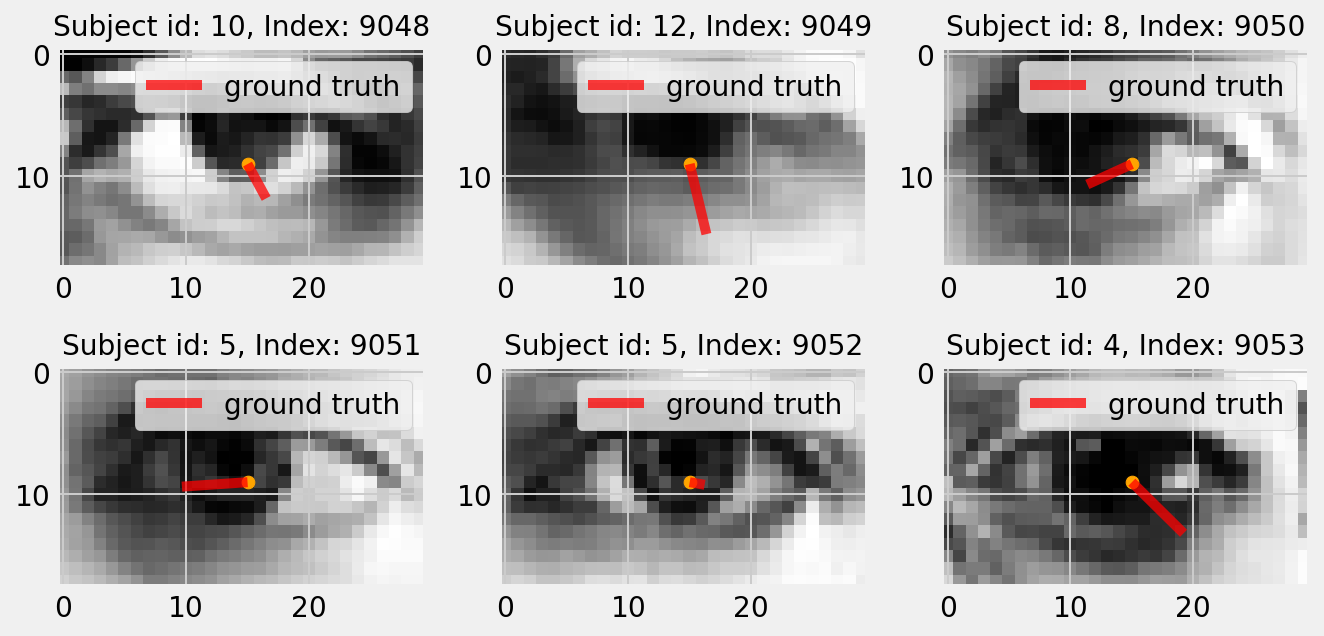

In [3]:
# visualize the eye images
plt.figure(figsize=(10, 5))
# randomly select an index, visualize following 6 images
start_idx = max(int(random.random() * len(train_df)) - 6, 0)

for offset in range(6):
    idx = offset + start_idx
    # Here, use iloc to get the row we want
    row = train_df.iloc[idx]
    
    plt.subplot(230 + offset + 1)
    # Please remember using decode_base64_img to decode image
    img_np = decode_base64_img(row['image_base64'])
    subject_id = row['subject_id']
    yaw, pitch = row['yaw'], row['pitch']
    xyz_gt = yaw_pitch2vec(np.array([yaw, pitch]))
    
    x_center, y_center = 15, 9
    length = 20
    
    plt.imshow(img_np, cmap="gray", vmin=0, vmax=256)
    plt.plot(
        [x_center, x_center + xyz_gt[0] * length],
        [y_center, y_center + xyz_gt[1] * length],
        linewidth=5, c="r", label="ground truth", alpha=0.75
    )
    plt.scatter([x_center], [y_center], s=40, c='orange')
    
    plt.legend()
    plt.title("Subject id: {}, Index: {}".format(subject_id, idx), fontsize=14)
plt.show()

## Section 1: Dataset with pandas
****

### Section 1.1: Compute mean yaw & pitch of that guy! (5 points)
Compute mean of yaw & pitch w.r.t. some subject.
<br/><br/>

#### *Now, playground!*

- Learn how to use `pandas.DataFrame.groupby`: [Document](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html?highlight=groupby#pandas.DataFrame.groupby)
- Modify the codes below and play with it. Notice that you don't change `train_df`.


In [4]:
# the mean values of each group
# group by 'subject_id'
df_mean = train_df.groupby("subject_id").mean()
df_mean

,yaw,pitch
subject_id,,
1,-0.000763,-0.165573
2,-0.003273,-0.118495
3,0.008314,-0.161163
4,0.000120,-0.149518
5,0.004634,-0.154804
6,-0.004170,-0.183341
7,-0.004327,-0.165714
8,0.004593,-0.173942
9,0.003335,-0.158397


![](figures/code_time.png)

**Complete code at `AppearanceGazeEst.py/mean_of_tgt_subject`**, where you may see more details.

In [5]:
# Local Test - Section 1.1
# Note: feel free to print out your result to debug if it cannot pass assert_eq

from AppearanceGazeEst import mean_of_tgt_subject

yaw_1, pitch_1 = mean_of_tgt_subject(train_df, 1)
yaw_10, pitch_10 = mean_of_tgt_subject(train_df, 10)

assert_eq(yaw_1, -0.000763)
assert_eq(pitch_1, -0.165573)
assert_eq(yaw_10, -0.000714)
assert_eq(pitch_10, -0.156507)

print("You pass the local test - Section 1.1 (5%)")

(-0.0007625028043039493, -0.16557314605933304)
(-0.0007137119082614544, -0.1565073859030575)
You pass the local test - Section 1.1 (5%)


### Section 1.2: Filter by yaw (5 points)
Count the number of images that meets the requirement(in comment) of the function `count_tgt_subject`, that counts the number of images of which yaw is larger(>) than yaw_threshold.
<br/><br/>

#### *Now, playground!*

- Learn how to use `pandas.DataFrame.loc`: [Document](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.loc.html)
- Modify the codes below and play with it. Notice that don't change `train_df`.

In [6]:
df_filtered = train_df.loc[train_df['yaw'] > 0.4]
df_filtered

,subject_id,yaw,pitch,image_base64
13305,10,0.675729,-0.217199,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
17352,2,0.613678,-0.270429,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
17518,7,0.404016,-0.209957,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
18412,10,0.489647,-0.278194,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
18812,7,0.404949,-0.326515,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
33621,7,0.405117,-0.269769,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...


![](figures/code_time.png)

**Complete code at `AppearanceGazeEst.py/count_tgt_subject`**

In [7]:
# Local Test - Section 1.2
# Note: feel free to print out your result to debug if it cannot pass assert_eq

from AppearanceGazeEst import count_tgt_subject

assert_eq(count_tgt_subject(train_df, 0.02), 19571)
assert_eq(count_tgt_subject(train_df, -0.02), 22876)

print("You pass the local test - Section 1.2 (5%)")

You pass the local test - Section 1.2 (5%)


### Section 1.3: Get minimial value of target column (5 points)
Get the minimial value of a target column specified by `col` with the function `get_min_val_of_tgt_col`.

![](figures/code_time.png)

**Complete code at `AppearanceGazeEst.py/get_min_val_of_tgt_col`**

**It should be really easy — just in one line! Find out what the inbuilt function you need.**

In [8]:
# Local Test - Section 1.3
# Note: feel free to print out your result to debug if it cannot pass assert_eq
from AppearanceGazeEst import get_min_val_of_tgt_col

assert_eq(get_min_val_of_tgt_col(train_df, 'yaw'), -0.7248519)

print("You pass the local test - Section 1.3 (5%)")

You pass the local test - Section 1.3 (5%)


### Section 1.4: Mean eye is the perfect eye? (10 points)
Psychological research indicated that mean face is impressive to most people. At the same time mean face is also involved in "whitening" process, a popular preprocessing techique in face detection. Now, it is high time that you should compute the mean eye.
<br/><br/>

#### *Now, playground!*

- Learn how to use `pandas.DataFrame.iterrows`: [Document](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.iterrows.html)
- Use `decode_base64_img` from gazelib.utils
- Modify the codes below and play with it. Notice that don't change `train_df`.

In [9]:
for idx, i in train_df.iterrows():
    if idx > 9:
        break
    print(f"{idx} | {i['yaw']}")

0 | -0.2029759287834167
1 | 0.1538750976324081
2 | -0.2402220219373703
3 | 0.0826812461018562
4 | 0.1417803913354873
5 | 0.0891403332352638
6 | -0.0527931116521358
7 | -0.2755689620971679
8 | 0.09529310464859
9 | -0.0662526190280914


[[119.43578571 113.5282381  108.98952381 106.22511905 104.46528571
  103.51240476 104.20107143 107.21040476 112.15388095 118.5877381
  125.8455     133.78171429 141.87395238 150.07378571 157.56557143
  164.17147619 169.50059524 173.98247619 177.32504762 180.09340476
  182.28854762 184.32483333 186.04645238 186.99480952 187.20833333
  186.41592857 184.62314286 182.2222619  180.29078571 179.31316667]
 [117.43459524 111.4327619  106.62209524 103.2215     100.46295238
   98.76942857  99.49345238 102.72488095 107.42169048 113.424
  120.45659524 128.44035714 136.8625     145.4897619  153.46185714
  160.39780952 165.78554762 169.75702381 172.34219048 174.00633333
  174.63945238 175.1252381  176.49604762 178.99569048 181.59778571
  183.4625     184.01452381 183.15371429 181.98542857 181.45740476]
 [115.15552381 107.8252619  101.28633333  95.97480952  92.07042857
   90.1475      90.8867619   93.96890476  98.57516667 104.62785714
  111.6982619  119.72933333 128.05242857 136.75985714 144.86919048

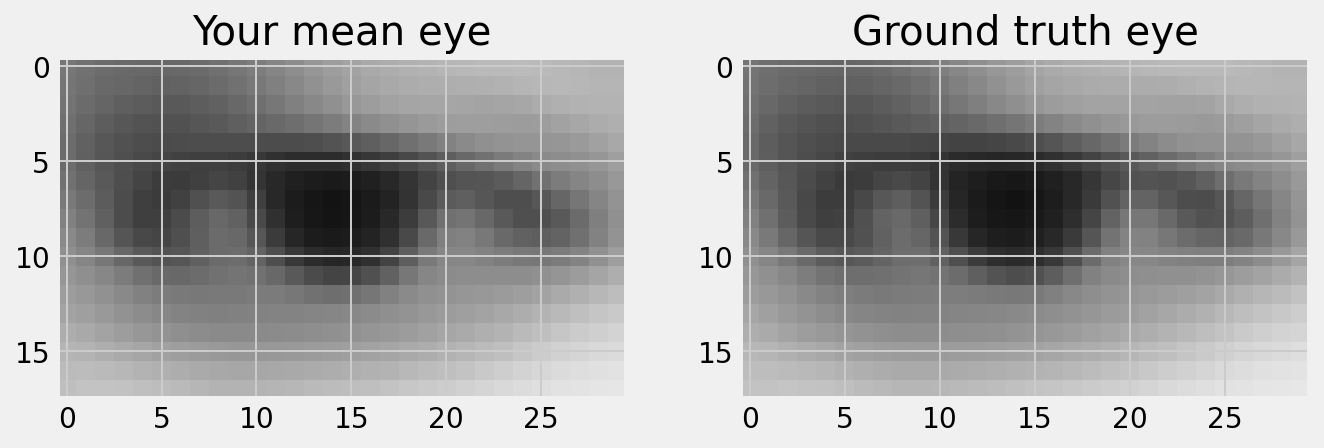

In [32]:
# Local Test - Section 1.4
from AppearanceGazeEst import compute_mean_eye

mean_eye = compute_mean_eye(train_df)
check_im_similarity(mean_eye)

![](figures/code_time.png)

**Complete code at `AppearanceGazeEst.py/compute_mean_eye`**

### Section 1.5: Does he or she wear eyeglasses? (10 points)
Statistics in recent research paper shows that current algorithms are not robust to the subjects with eyeglasses. Imagine you are now a researcher who wants to study this problem. Before diving deeper, you should add a column (with boolean values) in current data frame to inform you whether each row's subject wears eyeglasses or not.

<img src="figures/woglasses.png" style="zoom:50%" />
<br/><br/>

#### *Now, playground!*

- How to add a new column to the DataFrame from a list?
- Modify the codes below and play with it. Notice that don't change `train_df`.

In [33]:
df_toy = pd.DataFrame({'A':[0, 0, 0], 'B':[1, 1, 1]})
df_toy['new_col'] = [2, 2, 2]
df_toy

,A,B,new_col
0,0,1,2
1,0,1,2
2,0,1,2


![](figures/code_time.png)

**Complete code at `AppearanceGazeEst.py/add_glasses_info`**

In [34]:
# Local Test - Section 1.5 (5%)
from AppearanceGazeEst import add_glasses_info

ret_df = add_glasses_info(train_df)

assert not ret_df.loc[0]['has_glasses']
assert ret_df.loc[12]['has_glasses']

print("You pass the local test - Section 1.6 (5%)")

ret_df.head(13)

You pass the local test - Section 1.6 (5%)


,subject_id,yaw,pitch,image_base64,has_glasses
0,5,-0.202976,-0.300898,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,False
1,5,0.153875,-0.216009,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,False
2,6,-0.240222,-0.231348,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,False
3,6,0.082681,-0.148303,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,False
4,11,0.141780,-0.259967,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,False
5,14,0.089140,-0.223431,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,False
6,6,-0.052793,-0.056385,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,False
7,13,-0.275569,-0.115087,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,False
8,5,0.095293,-0.210037,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,False
9,2,-0.066253,-0.250547,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,False


![](figures/good_job_banner.png)
You should have completed **all cells(35 points)** in this section locally when you reach here! You have been equipped with skills to get/set anything you want by pandas.

**checklist**
- mean_of_tgt_subject (5 points)
- count_tgt_subject (5 points)
- get_min_val_of_tgt_col (5 points)
- compute_mean_eye (10 points)
- add_glasses_info (10 points)


## Section 2: KNN with numpy
****
Now we are going to do something crazy!
In this section, we will build a gaze estimation system by KNN(K-nearest neighbour).

![](figures/gaze_model_pipeline.png)

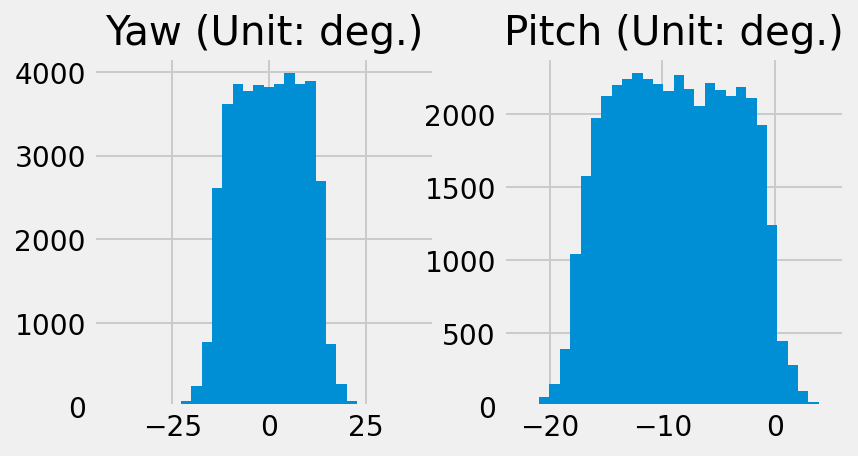

In [35]:
# IMPORTANT: run this cell before runnng any cell to activate auto re-import
%reload_ext autoreload
%autoreload 2
# make sure you get the correct dataset
del train_df
train_df = load_train_csv_as_df()

# visualize the distribution of the yaw and pitch
vis.vis_yaw_pitch(train_df)

### Section 2.0: Dataset split
Before moving on, first, split our dataset into `training set` and `validation set`.

- `Training set`: The sample of data used to generate the model or provide knowledge base for model.
- `Validation set`: The sample of data used to provide an unbiased evaluation of a model fit on the training dataset at our design process. We could test performance of model on this set.
- `Test set`: Other people will judge the performance of your model at their test dataset. The sample of data used to provide an unbiased evaluation of a final model fit on the training dataset.


![](figures/train_val_test.png)
<br/><br/>

In [36]:
# transform data into numpy arrays
def df2nptensor(df):
    imgs = []
    imgs_HOG = []
    gaze_dirs = []

    print_interval = 1000
    print_cnter = 0
    
    for _, i in df.iterrows():
        if print_cnter % print_interval == 0:
            print("[{} / {}]".format(print_cnter, len(df)), end='\r')
        print_cnter += 1
        im_arr = decode_base64_img(i['image_base64'])
        gaze_dirs.append([i['yaw'], i['pitch']])
        im = im_arr / 255
        
        imgs.append(im)
    
    gaze_dirs = np.array(gaze_dirs)
    imgs = np.array(imgs)
    
    return gaze_dirs, imgs

Start to generate sampled dataset, it may take ~10s.
train_X.shape: (4000, 18, 30)
train_Y.shape: (4000, 2)
val_X.shape: (1000, 18, 30)
val_X.shape: (1000, 2)


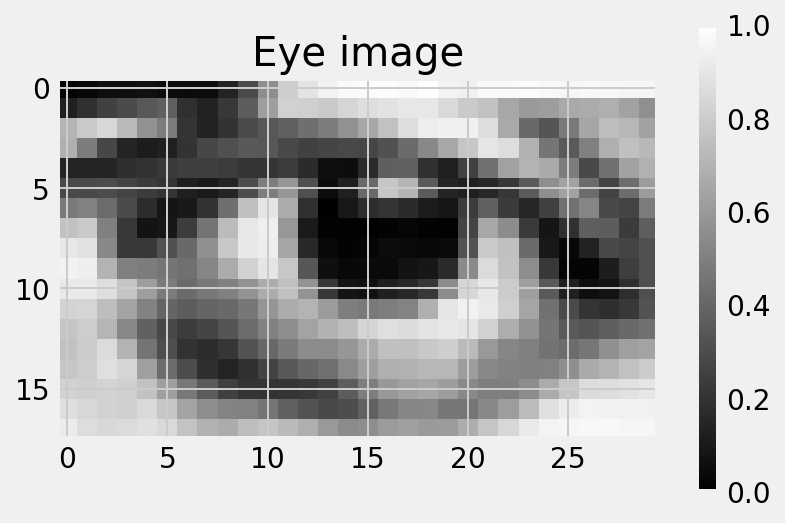

In [37]:
# For effciency, we only takes first 5,000 samples. Pick subject 5 as validation 
# set and the rest of the dataset as training set
SAMPLE_NUM = 5000
print("Start to generate sampled dataset, it may take ~10s.")
train_Y, train_X = df2nptensor(train_df[train_df["subject_id"] != 5][: int(SAMPLE_NUM * 0.8)])
val_Y, val_X = df2nptensor(train_df[train_df["subject_id"] == 5][: int(SAMPLE_NUM * 0.2)])

print("train_X.shape: {}".format(train_X.shape))
print("train_Y.shape: {}".format(train_Y.shape))
print("val_X.shape: {}".format(val_X.shape))
print("val_X.shape: {}".format(val_Y.shape))

# visulize an image (randomly sampled one, you could repeatedly run this cell)
plt.imshow(train_X[random.randint(0, train_X.shape[0])], vmin=0, vmax=1, cmap="gray")
plt.title("Eye image")
plt.colorbar()
plt.show()

### Section 2.1: K-top Eye Search Engine (10 points)

Here we aim at finding an eye in the database by Euclidean distances between image array, which is computed by the following equation.
$$
    d = \sum_i \sum_j || I_{ij}^a - I_{ij}^b ||_2
$$

After that, you are required to implement a simple eye search engine. It is defined as follows: for each sample in the validation set, find the top k samples in the training set, which is sorted by similarity. The simlarity is evaluated by Euclidean distance: the shorter the distance, the higher the similarity.  



**Algorithm**:
- Compute the Euclidean distance(norm-2) from the `val_x` to each element in `train_X`.
- Sort the euclidean distances.
- Return the first k indices of elements ascendingly.

You could start from more intuitive 2D cases, and then generalize your algorithm to the cases of images. 

Plus, for arrays, each sample is indexed by the first dimension. For example, in 2D case, each row in the matrix is a sample point.

**Example**:

- train_X = [[0, 0], [1, 1], [2.5, 2.5], [3.5, 3.5]]
- val_x = [2, 2]
- KNN_idx(train_X, val_x, 4) -> [2, 1, 3, 0]
<br/><br/>

#### *Now, playground!*

- Here is an example of computing euclidean distance between two images. You could repeatedly run following cells to see distance between different image pairs. Notice the use of `np.linalg.norm`: [Document](https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html)
- Learn how to use `np.argsort`: [Document](https://numpy.org/doc/stable/reference/generated/numpy.argsort.html)

[[[0.32156863 0.20784314 0.18823529 ... 0.5254902  0.32156863 0.22745098]
  [0.34117647 0.24705882 0.23137255 ... 0.55686275 0.4        0.30980392]
  [0.36470588 0.28627451 0.25882353 ... 0.56470588 0.4745098  0.40784314]
  ...
  [0.98823529 0.96470588 0.94509804 ... 0.89019608 0.90588235 0.89019608]
  [0.98823529 0.97254902 0.95686275 ... 0.92156863 0.90196078 0.87058824]
  [0.99607843 0.98039216 0.96078431 ... 0.93333333 0.90588235 0.86666667]]

 [[0.34509804 0.35686275 0.36078431 ... 0.61568627 0.50980392 0.45098039]
  [0.38039216 0.35686275 0.33333333 ... 0.61960784 0.5254902  0.49411765]
  [0.36862745 0.29019608 0.21960784 ... 0.6745098  0.58823529 0.54901961]
  ...
  [0.91764706 0.89019608 0.91372549 ... 0.88235294 0.9372549  0.97647059]
  [0.96862745 0.96470588 0.96470588 ... 0.9254902  0.95294118 0.98431373]
  [0.99607843 0.99215686 0.98823529 ... 0.96078431 0.97254902 0.99215686]]

 [[0.63529412 0.60392157 0.54509804 ... 0.98431373 0.98431373 0.99215686]
  [0.57647059 0.529411

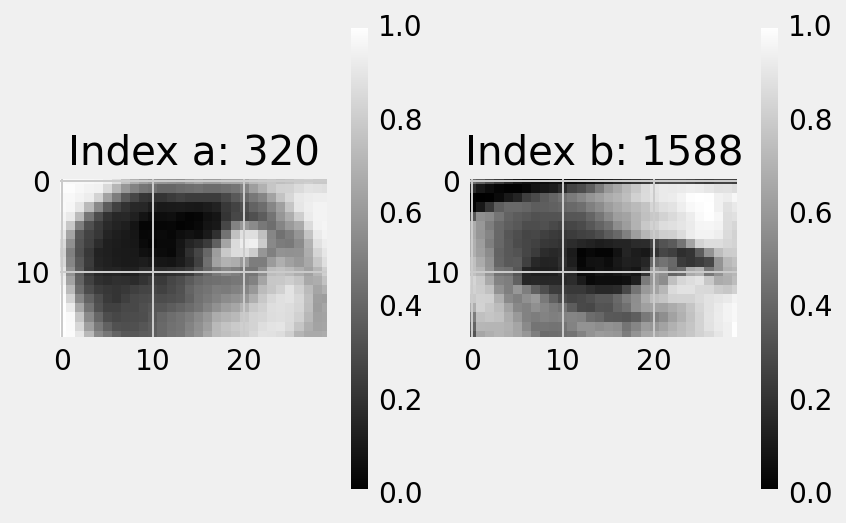

Euclidean distance: 7.330


In [48]:
# Example: Compute Euclidean distance of two images
# randomly sample image pair
#print(train_X.shape[2])
#print(train_X)
idx_a, idx_b = random.randint(0, train_X.shape[0]), random.randint(0, train_X.shape[0])
image_a = train_X[idx_a]
image_b = train_X[idx_b]
#print(image_a)
#print(image_a - image_b)
# compute euclidean distance by taking norm 2
dist = np.linalg.norm(image_a - image_b)

# visualize
plt.subplot(121)
plt.imshow(image_a, vmin=0, vmax=1, cmap="gray")
plt.colorbar()
plt.title("Index a: {}".format(idx_a))
plt.subplot(122)
plt.imshow(image_b, vmin=0, vmax=1, cmap="gray")
plt.colorbar()
plt.title("Index b: {}".format(idx_b))
plt.show()
print("Euclidean distance: {:.3f}".format(dist))

![](figures/code_time.png)

**Complete code at `AppearanceGazeEst.py/KNN_idxs`**

In [57]:

# Local Test 1 - Toy data
# Note: feel free to print out your result to debug if it cannot pass assert_eq_np
from AppearanceGazeEst import KNN_idxs
from gazelib.task_2_judge import assert_eq_np

sanity_trainX =  np.array([[0, 0], [1, 1], [2.5, 2.5], [3.5, 3.5]])
sanity_valX=  np.array([2, 2])

ret = KNN_idxs(sanity_trainX, sanity_valX, 100)

assert_eq_np(ret, np.array([2, 1, 3, 0]))
print("Pass local test 1@2.1 - toy data")

Pass local test 1@2.1 - toy data


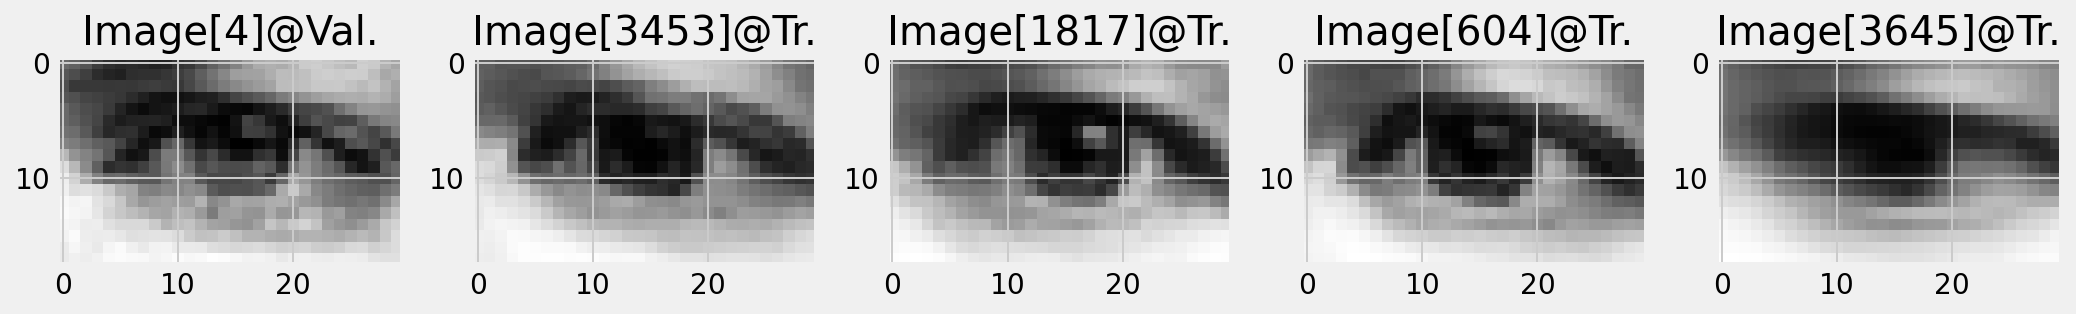

Pass local test 2@2.1 - eye images


In [56]:
# Local Test 2 - Eye images
# Note: feel free to print out your result to debug if it cannot pass assert_eq_np
from AppearanceGazeEst import KNN_idxs
from gazelib.task_2_judge import assert_eq_np

# pick the second image at validation set and find four images at training set with most simlarity
idx = 10
ret = KNN_idxs(train_X, val_X[idx], 4)
assert_eq_np(ret, np.array([3453, 1817, 604, 3645]))

plt.figure(figsize=(16, 4))
plt.subplot(151)
plt.imshow(val_X[idx] , vmin=0, vmax=1, cmap="gray")
plt.title("Image[4]@Val.")

for i in range(4):
    plt.subplot(152 + i)
    plt.imshow(train_X[ret[i]] , vmin=0, vmax=1, cmap="gray")
    plt.title("Image[{}]@Tr.".format(ret[i]))
plt.show()

print("Pass local test 2@2.1 - eye images")

### Section 2.2: From Search Engine To A Baseline Estimator - 1-NN estimator (10 points)

At the previous section, we built a search engine of eye images. In fact, by simply injecting lines of code at previous process, the "search engine" could be converted into a gaze estimator.

![](figures/1_NN_new.png)

- Compute the Euclidean distance from the query example (`val_x`) to the labeled examples.
- Find the image with most simlarity (one image in `train_X` with nearest euclidean distance).
- Take its corresponding label as output (`train_Y[min_idx]`).

You could start from more intuitive 2D cases, and then generalize your algorithm to the case of images. Intuitively, it takes the label of nearest sample as output. Therefore, it is called "one nearest neighbour".

**Example(2D Case)**:
- `train_X` = [[0, 0], [1, 1], [2.5, 2.5], [3.5, 3.5]]
- `train_Y` = [[20], [30], [40], [50]]
- `val_x` = [2, 2]
- `KNN_idx(train_X, val_x, 1)` -> [2]
- `oneNN(train_X, train_Y, val_x)` -> `train_Y[2]` <-> [40]

![](figures/code_time.png)

**Complete code at `AppearanceGazeEst.py/oneNN`**

**You can reuse the `KNN_idxs` you have implemented**

In [64]:
# Local Test 1 - Toy data
# Note: feel free to print out your result to debug if it cannot pass assert_eq_np
from AppearanceGazeEst import oneNN
from gazelib.task_2_judge import assert_eq_np

sanity_trainX = np.array([[0, 0], [1, 1], [2.5, 2.5], [3.5, 3.5]])
sanity_trainY = np.array([[20], [30], [40], [50]])
sanity_valX=  np.array([2, 2])

ret = oneNN(sanity_trainX, sanity_trainY, sanity_valX)

assert_eq_np(ret, 40)
print("Pass local test 1@2.2 - toy data")

2.8284271247461903
1.4142135623730951
0.7071067811865476
2.1213203435596424
2
[40]
Pass local test 1@2.2 - toy data


6.101841069444131
5.707594918522231
6.342220438637575
7.447022684710298
5.763591995892602
5.201046829240616
7.906320015896879
6.381304392648417
7.1306778573368055
7.610113871756425
6.91955533681233
5.111380732737674
4.557778923119662
4.598672559750602
8.124376295819786
6.335235554799388
6.493083890441006
7.068685920728507
7.103500228341008
8.791550765346768
5.542631950168168
8.244784447651453
3.9013951703562073
4.69576526852992
5.400778846534395
5.27542087036448
6.0804841568496295
8.260062659588646
4.618983612407367
6.233262710157565
4.3010687762722135
5.81477919228055
7.288400669126629
6.869582028567139
5.9389331168742014
7.773014963972619
4.755693889984961
6.447490563283468
8.083310919242637
6.9232126026327805
6.974920746188402
7.030423259738539
6.984086926991085
6.2218525731908905
5.560693049390739
6.729821962908185
5.927557029140909
7.072026867443366
7.824670416575237
6.65395327565054
7.863930280829394
5.354499521785076
8.445178846633977
5.11813986057914
6.467748634202833
4.0579955

9.969903961712319
7.188007441592709
4.491776415108147
7.433688914175872
7.418224179733087
6.478541754744956
6.352296021465712
7.925800655599109
3.3850179895675994
7.293878343112222
6.901057204667933
5.142339947020126
5.786718011455061
5.490767477268286
3.3195122926151006
6.639019952409319
6.137300006098746
5.204005791537369
7.303586516857812
5.1934569783901985
8.090363356410782
3.0752375089178536
6.867403460991642
5.668929597688156
9.247617605229415
5.511680651698288
5.359187621704337
7.19514873515693
6.65873114788454
7.57997828110492
6.772327618802393
6.697583444106746
7.931213309436627
6.0517453419627385
5.121367440422835
6.443844912387476
8.207340044351398
5.989985234247034
6.491068006118394
6.928917944608803
5.677834168574186
7.165783320469901
4.861248979206024
6.753867987685191
6.556698562537751
6.196079672375155
8.45817627310842
6.230816001997629
6.992554946713991
5.995980968443204
7.525804895891636
7.3626978406357875
8.129328527897886
6.755508382238825
6.760099596826645
6.262497

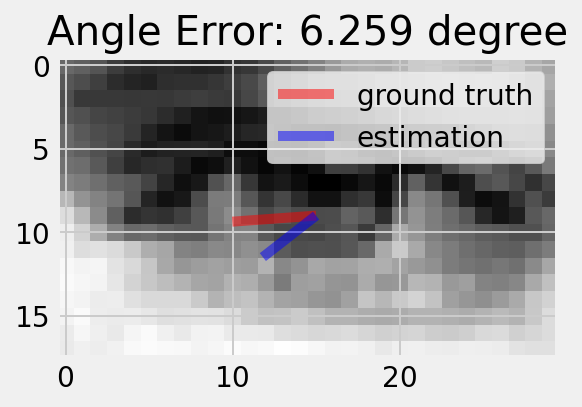

In [65]:
# Local Test 2 - Eye images
# Note: feel free to print out your result to debug if it cannot pass assert_eq_np
from AppearanceGazeEst import oneNN
from gazelib.task_2_judge import assert_eq_np
from gazelib.task_3_judge import compute_angle_error

idx = 10
ret = oneNN(train_X, train_Y, val_X[idx])
assert_eq_np(ret, np.array([ 0.1283756,  -0.09948426]))

print("Pass local test 2@2.2 - eye images")
plt.figure(figsize=(4, 3))
vis.visualize_est(val_X[idx], ret, val_Y[idx])
plt.title("Angle Error: {:.3f} degree".format(compute_angle_error(val_Y[idx], ret)));

#### *Now, playground!*

- Run the following cell repeatedly and see what you get.

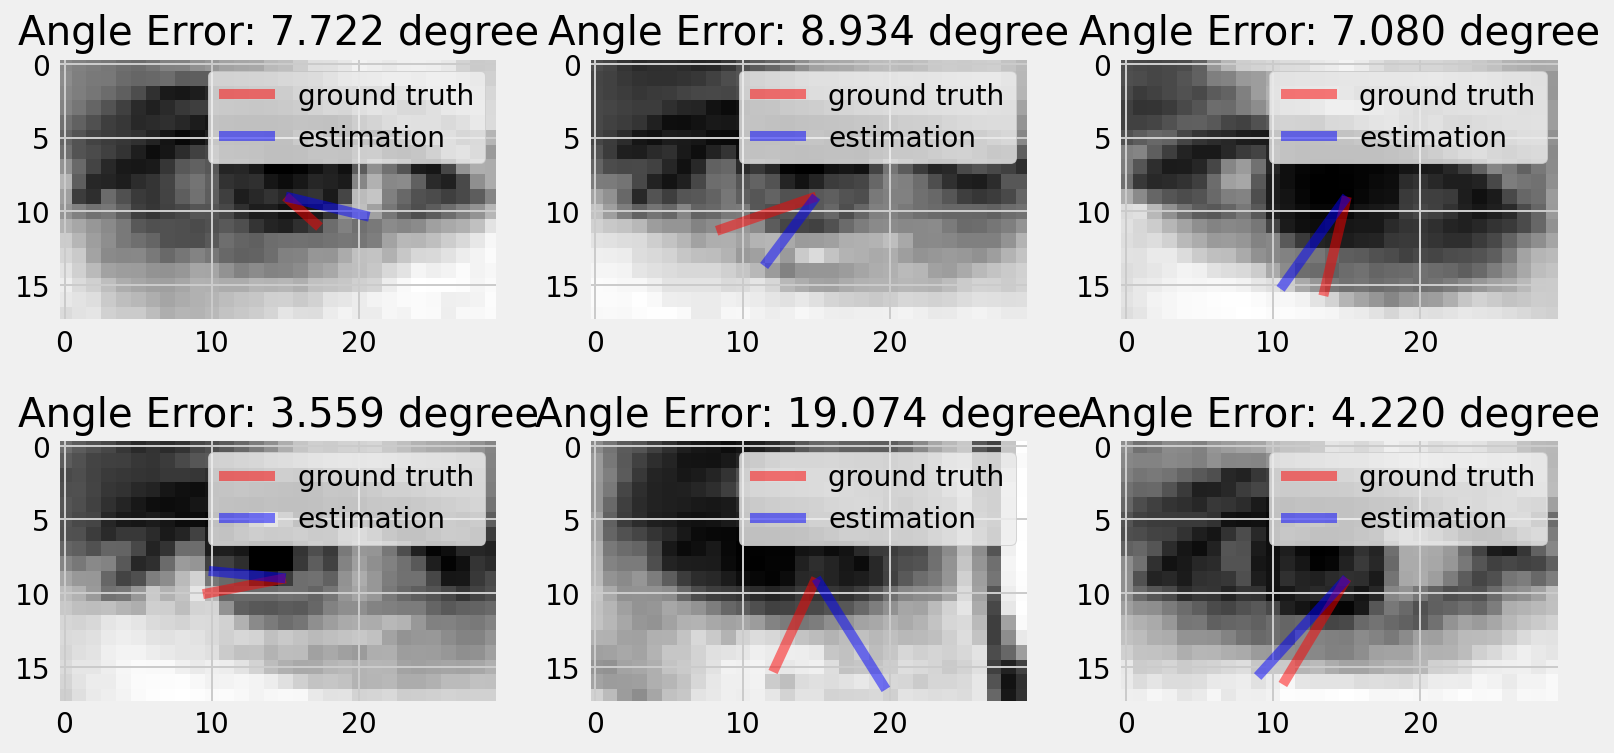

In [66]:
# Playground
from AppearanceGazeEst import oneNN
from gazelib.task_2_judge import assert_eq_np

plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(231 + i)
    random_idx = random.randint(0, val_X.shape[0])
    ret = oneNN(train_X, train_Y, val_X[random_idx])

    vis.visualize_est(val_X[random_idx], ret, val_Y[random_idx])
    plt.title("Angle Error: {:.3f} degree".format(compute_angle_error(val_Y[random_idx], ret)));

### Section 2.3: From  1-NN estimator to K-NN estimator (15 points)

For the 1-NN estimation of gaze, a most simlar eye is found and its gaze information is copied as output. It is also intuitive to rely on multiple samples in the training set and output an average of them as the final result. Here comes the K-NN.

- Compute the Euclidean distance from the query example(`val_x`) to the labeled examples.
- Find the k images with most simlarity (k images in `train_X` with nearest euclidean distance).
- Take the `median` of their corresponding label as output.

You could start from more intuitive 2D cases, and then generalize your algorithm to the case of images.

**Example(2D Case)**:
- `train_X` = [[0, 0], [1, 1], [2.5, 2.5], [3.5, 3.5]]
- `train_Y` = [[20], [30], [40], [50]]
- `val_x` = [2, 2]
- `KNN_idx(train_X, val_x, 2)` -> [2, 1]
- `KNN(train_X, train_Y, val_x, 2)` -> `np.mean(train_Y[[2, 1])` <-> (40 + 30) / 2 <-> 35

![](figures/code_time.png)

**Complete code at `AppearanceGazeEst.py/KNN`**

In [132]:
# Local Test 1 - Toy data
# Note: feel free to print out your result to debug if it cannot pass assert_eq_np
from AppearanceGazeEst import KNN
from gazelib.task_2_judge import assert_eq_np

sanity_trainX = np.array([[0, 0], [1, 1], [2.5, 2.5], [3.5, 3.5]])
sanity_trainY = np.array([[20], [30], [40], [50]])
sanity_valX=  np.array([2, 2])

ret = KNN(sanity_trainX, sanity_trainY, sanity_valX, 2)
assert_eq_np(ret, 35)
print("Pass local test 1@2.3 - toy data")

[2 1 3 0]
2
[2 1]
<class 'numpy.ndarray'>
[35.]
Pass local test 1@2.3 - toy data


[3453 1817  604 ... 3651 3473 3015]
10
[3453 1817  604 3645 1055  289 3741  288 3359 1424]
<class 'numpy.ndarray'>
[ 0.06985615 -0.07175483]
Pass local test 2@2.3 - eye images


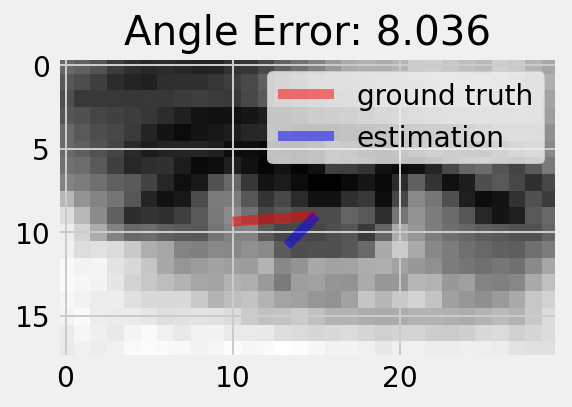

In [131]:
# Local Test 2 - Eye images
# Note: feel free to print out your result to debug if it cannot pass assert_eq_np
from AppearanceGazeEst import KNN
from gazelib.task_2_judge import assert_eq_np
from gazelib.task_3_judge import compute_angle_error

idx = 10
ret = KNN(train_X, train_Y, val_X[idx], 10)
assert_eq_np(ret, np.array([ 0.06985615, -0.07175483]))

print("Pass local test 2@2.3 - eye images")
plt.figure(figsize=(4, 3))
vis.visualize_est(val_X[idx], ret, val_Y[idx])
plt.title("Angle Error: {:.3f}".format(compute_angle_error(val_Y[idx], ret)));

#### *Now, playground!*

- Run the following cell repeatedly and see what you get.

[2169  111 1875 ... 3473 3015 3651]
10
[2169  111 1875 2507 3080  952 2195 1112  132 2086]
<class 'numpy.ndarray'>
[ 0.10717073 -0.25915346]
[1961 1513 1316 ... 3792 3086 3015]
10
[1961 1513 1316 2470  629 1172 2353 1612  467 1701]
<class 'numpy.ndarray'>
[-0.1227179  -0.23128704]
[2507 2169 1112 ... 3473 3651 3015]
10
[2507 2169 1112 2736  111 2394 1220  835 2086  298]
<class 'numpy.ndarray'>
[-0.01856591 -0.16130969]
[2507 2912  484 ... 3338 3015 3651]
10
[2507 2912  484 1997  437 1734 3258 2238 2955 1226]
<class 'numpy.ndarray'>
[-0.09297507 -0.0679495 ]
[1817 3645  288 ... 3651 3473 3015]
10
[1817 3645  288 1055  604 2861 2603 3453 3199  440]
<class 'numpy.ndarray'>
[-0.0084292 -0.0755437]
[ 857 3662 1070 ... 2246 3086 3015]
10
[ 857 3662 1070  995  574 3895 2224 3906 2037  733]
<class 'numpy.ndarray'>
[ 0.09953844 -0.15840484]


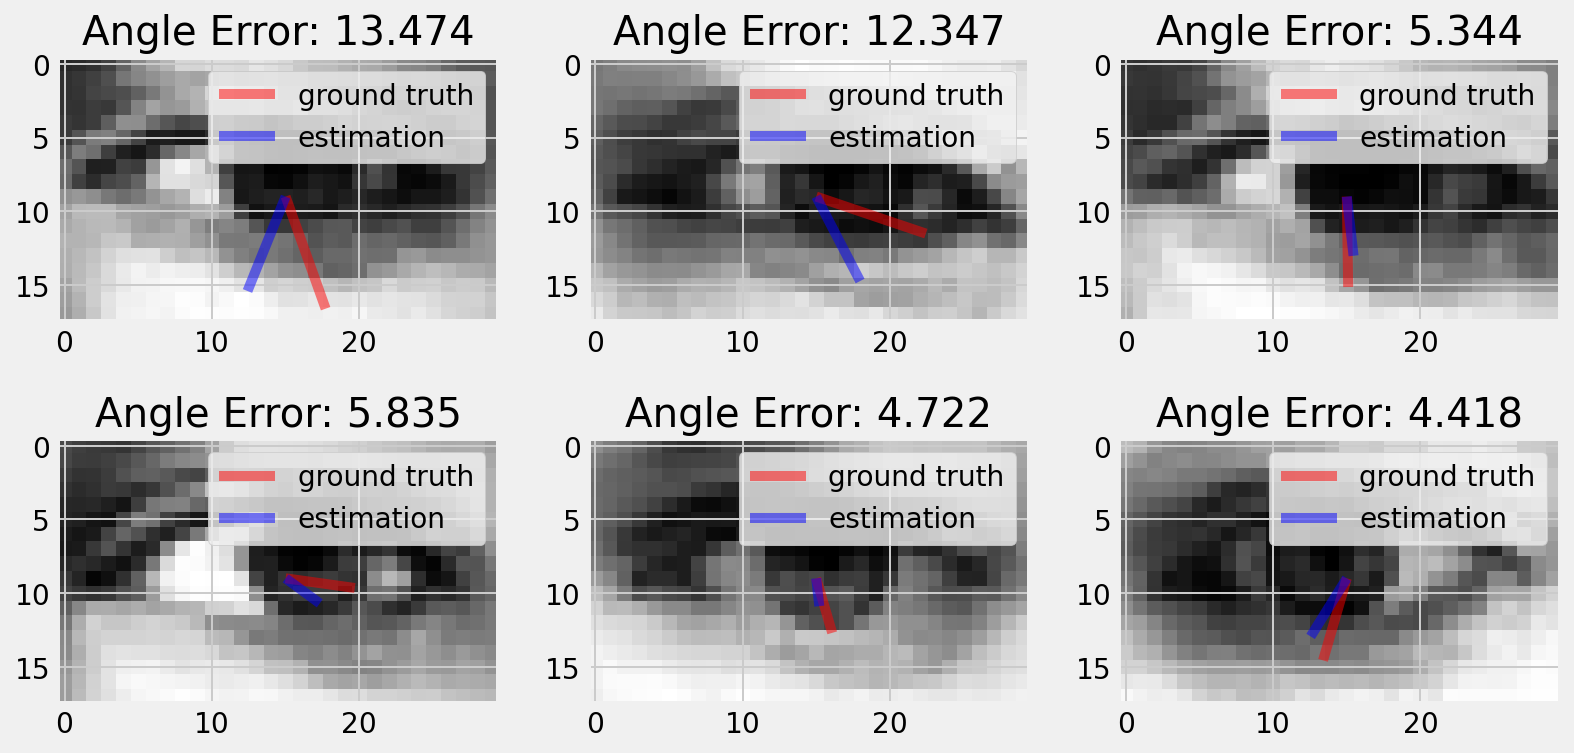

In [133]:
# Playground
from AppearanceGazeEst import KNN
from gazelib.task_2_judge import assert_eq_np

plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(231 + i)
    random_idx = random.randint(0, val_X.shape[0])
    ret = KNN(train_X, train_Y, val_X[random_idx], k=10)

    vis.visualize_est(val_X[random_idx], ret, val_Y[random_idx])
    plt.title("Angle Error: {:.3f}".format(compute_angle_error(val_Y[random_idx], ret)));

### Section 2.4: Demo: Have you ever heard about Lenna?
Visualize the gaze over an image directly. 

[GazeLib] Demo image exists and passed md5 cheking.


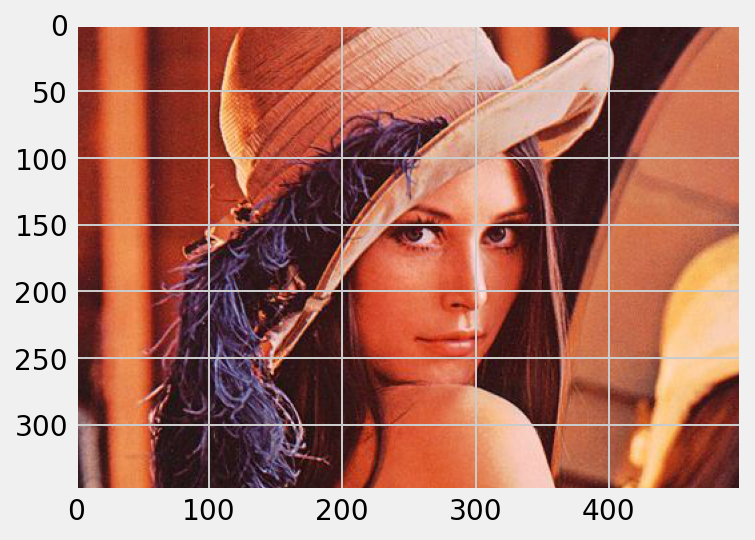

In [134]:
from gazelib.utils import download_demo_Img, load_demo_Img

download_demo_Img()
# You can have your own image at assignment_Gaze/dataset,
# the load_deomo_Img() will return first noncsv as an image back, with the support of most
# formats of image
demo_im = load_demo_Img()

plt.imshow(demo_im)
plt.show()

In [135]:
from gazelib.demo import estimate_gaze
from gazelib.task_3_judge import convert_to_unit_vector
import numpy as np

def eyeim2gaze(eye_im):
    y_est = KNN(train_X, train_Y, eye_im, k=5)
    
    return convert_to_unit_vector(y_est)


estimate_gaze(demo_im, eyeim2gaze)

ModuleNotFoundError: No module named 'cv2'

![](figures/good_job_banner.png)
You should have completed **all cells (35 points)** in this section locally when you reach here! You have been equipped with skills to get/set anything you want by pandas.

**checklist**
- KNN_idxs (10 points)
- oneNN (10 points)
- KNN (15 points)


## Reference
```Bibtex
[1] @ARTICLE{
    8454246, 
    author={D. {Lian} and L. {Hu} and W. {Luo} and Y. {Xu} and L. {Duan} and J. {Yu} and S. {Gao}}, 
    journal={IEEE Transactions on Neural Networks and Learning Systems}, 
    title={Multiview Multitask Gaze Estimation With Deep Convolutional Neural Networks}, 
    year={2019}, 
    volume={30}, 
    number={10}, 
    pages={3010-3023}, 
    keywords={computer vision;convolutional neural nets;estimation theory;gaze tracking;multiview cameras;multiview gaze tracking data;convolutional neural networks architecture;multiview multitask gaze point estimation solution;multiview eye images;gaze direction estimation;deep convolutional neural networks;Estimation;Gaze tracking;Head;Task analysis;Feature extraction;Cameras;Robustness;Convolutional neural networks (CNNs);gaze tracking;multitask learning (MTL);multiview learning}, 
    doi={10.1109/TNNLS.2018.2865525}, 
    ISSN={2162-2388}, 
    month={Oct},
}
```